In [1]:
# imports
import numpy as np
import pandas as pd
import pyfaidx
from trtools.utils import utils

In [2]:
# Global variables for oligo construction. These cannot change
# R2 primer-(var + genomic context)-minP-spacer-filler

# FIVE_PRIME_ADAPT = 'AGGACCGGATCAACT'
R2_PRIMER = 'GTGCTCTTCCGATCT'
GLOBAL_FILLER_SEQ = 'TAACCAGGCGTGTTAGCTGCTGTGCTGTCCTACGAGTAAACAGTAGAGTCCGTGGGCACGCGAGCACGGTGAGTCGACTCTGGCCTCATCACCATTTAGTTTGCGCAAGCGCTCTTTTTATAGGACCTGTCTTACATCCCTCATTAACGGAATCGATTACCGGCTAGCGTTGAAATGGAGAAACCGGCTTGCAGTCGAAA'
MIN_PROMOTER = 'CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGT'
SPACER = 'GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG'
PROBE_LEN = 300

MIN_STR_LEN = 0
MAX_STR_LEN = 55

MAX_ALLELE_LEN = 5
MIN_FILLER_LEN = 5
REQUIRED_ELTS_LEN = len(R2_PRIMER) + len(MIN_PROMOTER) + len(SPACER) 

MAX_VREG = PROBE_LEN - (REQUIRED_ELTS_LEN) - MIN_FILLER_LEN
COPY_NUM_VAR = ['m5', 'p5']

# percentage of GC in repeat unit to cutoff if it is >0.8 & >30bp
GC_PERC_CUTOFF = 0.8
GC_MAX_LEN = 30
# maximum length of homopolymer; subject to change
HOMOPOLYMER_MAX_LEN = 30

In [3]:
# taken from Uber Design
def getGCPercent (seq):
	"""
	Compute the GC percentage of a sequence

	Arguments
	---------
	seq : str
	  Input sequence

	Returns
	-------
	gcperc : float
	  GC percentage of the input sequence

	Example
	-------
	GetGC("ACAC")
	> 0.5
	"""
	#converts it to uppercase
	seq = seq.upper()
	
    # computes length of sequence + counts number of GCs
	STRLen = len(seq)
	CGCount = seq.count('C') + seq.count('G')
	gcperc = CGCount/STRLen		
	return gcperc

In [4]:
def generate_vreg(path_genome, path_bed_file, path_hipstr, outdir):
    # create an empty list to be converted to a dataframe later
    seq_list = []
    # keep track of oligos that do not make the final cut
    max_str = []
    gc_max = []
    homo_max = []

    # load in fasta files using pyfaidx and csv/bed files using pandas
    genome = pyfaidx.Fasta(path_genome)
    colnames=['chr', 'start_str', 'end_str', 'rpt_unit', 'phenotype']
    bed_df = pd.read_csv(path_bed_file, names=colnames)

    # load in hipstr reference files using pandas
    str_heading = ['chr', 'str_start', 'str_end', 'str_len', 'num_rpts', 'name', 
                'rpt_unit']
    hipstr_df = pd.read_csv(path_hipstr, sep='\t', names=str_heading)

    # merge using the chromosome, str start site to also load in hipstr info
    bed_df = bed_df.merge(hipstr_df, left_on=['chr', 'start_str'],
                        right_on=['chr', 'str_start'])

    # remove the rpt unit column from the input bed file; rpt unit may have been 
    # swapped due to strandedness/naming conventions
    bed_df = bed_df.drop(labels=['rpt_unit_x'], axis=1)

    # checks to make sure the length of each start coordinate is the same
    assert len(bed_df[bed_df['start_str']==bed_df['str_start']])== len(bed_df)

    bed_df['GC_perc'] = bed_df['rpt_unit_y'].map(getGCPercent)

    bed_df['full_len_str'] = bed_df['str_len'] * bed_df['num_rpts']

    # figure out what is the maximum context length that can be generated

    # add in a column called max_str_size which is the longest str region that
    # will be generated (5 * lenght of rpt unit) + length of the str region
    bed_df['max_str_size'] = (MAX_ALLELE_LEN * bed_df['rpt_unit_y']).str.len()+\
        bed_df['full_len_str']


    # get rid of any STRs where the p5 allele size is > MAX_STR_LEN (=50)
    max_str = bed_df[bed_df['max_str_size'] > MAX_STR_LEN].name.to_list()
    print(len(max_str))
    bed_df = bed_df[bed_df['max_str_size'] <= MAX_STR_LEN]

    # get rid of any STRs that have increased enriched GC regions that are long
    gc_max = bed_df[(bed_df['GC_perc'] > GC_PERC_CUTOFF) & 
                        (bed_df['max_str_size'])].name.to_list()
    print(len(gc_max))

    # bed_df = bed_df.drop(bed_df[(bed_df['GC_perc'] > GC_PERC_CUTOFF) & 
    #                             (bed_df['max_str_size'] > GC_MAX_LEN)].index)

    # removes any STRs that are homopolymers & have p5 sequences too long to be 
    # captured by Illumina
    # arbitrary number currently
    homo_max= bed_df[(bed_df['str_len'] == 1) & 
                            (bed_df['max_str_size'] > HOMOPOLYMER_MAX_LEN)].name.to_list()
    print(len(homo_max))
    bed_df = bed_df.drop(bed_df[(bed_df['str_len'] == 1) & 
                            (bed_df['max_str_size'] > HOMOPOLYMER_MAX_LEN)].index)


    # drops any STRs that may have been duplicated
    bed_df = bed_df.drop_duplicates(subset="name")

    # gives list of different columns to be looped through
    name_list = bed_df['name']
    chromosome = bed_df['chr']
    start = bed_df['start_str']
    end = bed_df['end_str']
    rptUnit = bed_df['rpt_unit_y']
    max_str_size = bed_df['max_str_size']

    # give list of number of repeats used to generate the perfect STR
    rpt_len = bed_df['num_rpts']
    
    for (chrom, str_start, str_end, rpt, name, str_size, num_rpts) in \
        zip(chromosome, start, end, rptUnit, name_list, max_str_size, rpt_len):

        max_context_size = PROBE_LEN - REQUIRED_ELTS_LEN - MIN_FILLER_LEN - \
            str_size

        left_flank = str(genome[chrom][str_start-int(np.ceil(max_context_size/2)):str_start-1]).upper()
        str_refseq = str(genome[chrom][str_start-1:str_end]).upper()
        right_flank = str(genome[chrom][str_end:str_end+int(np.floor(max_context_size/2))]).upper()

        for copy_num_var in COPY_NUM_VAR:
            if (num_rpts.is_integer()):
                if (str_refseq[:(len(rpt))] == rpt):
                    start_ref_rpt = str_refseq[:len(rpt)]
                    perf_seq = start_ref_rpt*int(num_rpts)
                    assert (len(perf_seq) == int((int(num_rpts)*len(rpt))))                    
                    # print("rpt: " + rpt + " perfect_str_seq: " + perf_seq + \
                    # " lenght of str: " + str(num_rpts) + " ref seq: "+ str_refseq)
                    # took a look and the sequences look good :-)

                    if(copy_num_var == "p5"):
                        perf_p5_seq = perf_seq + (5*start_ref_rpt)
                        p5_seq = name+"_p5 "+chrom+" "+ str(num_rpts+5) + " " +\
                            str(str_start) + " " + str(str_end) + " " + rpt + \
                                " p5 " + left_flank + " " + perf_p5_seq + " " +\
                                    right_flank + " " + str_refseq
                    elif(copy_num_var == "m5"):
                        perf_m5_seq = perf_seq[:-1*(len(rpt)*5)]
                        if len(perf_m5_seq) == 0:
                            perf_m5_seq = rpt
                        m5_seq = name+"_m5 "+chrom+" "+ str(num_rpts-5) + " " +\
                            str(str_start) + " " + str(str_end) + " " + rpt + \
                                " m5 " + left_flank + " " + perf_m5_seq + " " +\
                                    right_flank + " " + str_refseq
                    else:
                        raise Exception ("invalid copy number variation")
                else:
                    # assign new rpt unit which is beginning of the reference seq
                    # realized could collapse the this and the first case 🙃
                    start_ref_rpt = str_refseq[:len(rpt)]
                    perf_seq = start_ref_rpt*int(num_rpts)
                    assert (len(perf_seq) == int((int(num_rpts)*len(rpt))))

                    if(copy_num_var == "p5"):
                        perf_p5_seq = perf_seq + (5*start_ref_rpt)
                        p5_seq = name+"_p5 "+chrom+" "+ str(num_rpts+5) + " " +\
                            str(str_start) + " " + str(str_end) + " " + rpt + \
                                " p5 " + left_flank + " " + perf_p5_seq + " " +\
                                    right_flank + " " + str_refseq
                    elif(copy_num_var == "m5"):
                        perf_m5_seq = perf_seq[:-1*(len(rpt)*5)]
                        if len(perf_m5_seq) == 0:
                            perf_m5_seq = start_ref_rpt
                        m5_seq = name+"_m5 "+chrom+" "+ str(num_rpts-5) + \
                            " " + str(str_start) + " " + str(str_end) + \
                                " " + rpt + " m5 " + left_flank + " " + \
                                    perf_m5_seq + " " + right_flank + " " \
                                        + str_refseq
                    else:
                        raise Exception ("invalid copy number variation")
                    # took a look and the sequences look good :-)
                    # print("rpt: " + rpt + " perfect_str_seq: " + perf_seq + \
                    # " lenght of str: " + str(num_rpts) + " ref seq: " + \
                    # str_refseq + " new rpt: " + start_ref_rpt)
            else:
                whole_num_rpts = int(np.floor(num_rpts))
                start_ref_rpt = str_refseq[:len(rpt)]
                beginning_of_rpt = whole_num_rpts*start_ref_rpt
                # calculates the decimal value of the end of the STR
                # for example if rpt_unit = AAAAC and the number of repeats = 3.8
                # takes 0.8 * 5 (length of repeat unit)=4 then adds on AAAA (len=4)
                dec_val = num_rpts - int(np.floor(num_rpts))
                substr_len = round(dec_val * len(rpt))
                end_of_rpt = start_ref_rpt[:substr_len]
                perf_seq = beginning_of_rpt+end_of_rpt

                # need the last STR repeat unit for p5 use
                # rather than starting at the given repeat unit which does not end
                # as it should, takes the last rpt unit and adds 5 of those
                ending_STR_rpt = perf_seq[-1*len(start_ref_rpt):]

                if(copy_num_var == "p5"):
                    perf_p5_seq = perf_seq + (5*ending_STR_rpt)
                    p5_seq = name+"_p5 "+chrom+" "+ str(num_rpts+5) + " " + \
                        str(str_start) + " " + str(str_end) + " " + rpt + \
                            " p5 " + left_flank + " " + perf_p5_seq + " " +\
                                right_flank + " " + str_refseq
                elif(copy_num_var == "m5"):
                    perf_m5_seq = perf_seq[:-1*(len(rpt)*5)]
                    if (num_rpts-5 < 1):
                        perf_m5_seq = ending_STR_rpt
                    m5_seq = name+"_m5 "+chrom+" "+ str(num_rpts-5) + " " + \
                        str(str_start) + " " + str(str_end) + " " + rpt + \
                            " m5 " + left_flank + " " + perf_m5_seq + " " +\
                                right_flank + " " + str_refseq
                else:
                    raise Exception ("invalid copy number variation")
                
        ref_seq = name+"_ref "+chrom+" "+ str(num_rpts) + " " + \
            str(str_start) + " " + str(str_end) + " " + rpt + " ref " + \
                left_flank + " " + perf_seq + " "+ right_flank + " " +str_refseq

        seq_list.append(m5_seq)
        seq_list.append(ref_seq)
        seq_list.append(p5_seq)

    split_seq = [string.split(" ") for string in seq_list]
    column_names = ['name', 'chr', 'num_rpts', 'start', 'end', 'rpt_unit', 
                    'allele', 'left_flank', 'str', 'right_flank', 'ref_seq']
    vreg_df = pd.DataFrame(split_seq, columns=column_names)
    vreg_df['vreg'] = vreg_df['left_flank'] + vreg_df['str']+vreg_df['right_flank']

    vreg_len = (vreg_df['vreg']).str.len()
    vreg = vreg_df['vreg']

    filler_len = []
    oligo_list = []
    size_check = []    

    for i in vreg_len:
        filler_len.append(PROBE_LEN-i-REQUIRED_ELTS_LEN)

    for j, seq in zip(filler_len, vreg):
        assert(j >= MIN_FILLER_LEN)
        filler_seq = GLOBAL_FILLER_SEQ[0:j]
        size_check.append(R2_PRIMER + seq + MIN_PROMOTER + 
                            SPACER + filler_seq)
        oligo_list.append(R2_PRIMER + '\t' + seq + '\t' + MIN_PROMOTER + '\t' + 
                            SPACER + '\t' + filler_seq)
        
    for line in size_check:
        assert(len(line) == PROBE_LEN)

    split_strings = [string.split('\t') for string in oligo_list]
    column_headers = ['R2 primer', 'vreg', 'minP', 'spacer', 
                    'filler']
    oligo_df = pd.DataFrame(split_strings, columns=column_headers)

    final_df = pd.merge(left=vreg_df, right=oligo_df)
    final_df['final_oligo'] = final_df['R2 primer'] + final_df['vreg'] + \
        final_df['minP'] + final_df['spacer'] + final_df['filler']

    cols = ['name', 'chr', 'start', 'end', 'R2 primer', 'left_flank', 'str', 
            'right_flank', 'minP', 'spacer', 'filler', 'rpt_unit', 'num_rpts',
            'vreg', 'final_oligo']
    final_df = final_df[cols]
    final_df = final_df.drop_duplicates(subset='final_oligo')
    # homo_max += max_str+gc_max
    # cut_df = pd.DataFrame(gc_max)
    return final_df
    # final_df.to_csv(outdir+'probeseq.tsv')

In [6]:
oligo_df = generate_vreg(path_genome='/Users/user/Desktop/MPRA/lentiSTR design/hg38.fa', 
                       path_bed_file='/Users/user/Downloads/final STR list - v7_organized.csv',
                       path_hipstr='/Users/user/Desktop/MPRA/lentiSTR design/hg38.hipstr_reference.bed.gz',
                       outdir='/Users/user/Desktop/')

51
16
9


In [7]:
oligo_df.to_csv('/Users/user/Desktop/probeseq_fin.tsv', sep='\t')

In [8]:
oligo_df

,name,chr,start,end,R2 primer,left_flank,str,right_flank,minP,spacer,filler,rpt_unit,num_rpts,vreg,final_oligo
0,Human_STR_1202973_m5,chr5,177616775,177616795,GTGCTCTTCCGATCT,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,TTTTTTTTTTTTTTTT,GAAACAGGGTCTTGACTGTCACCCAGGCTGCAGTGCAGTGGCCAAA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAG,T,16.0,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
1,Human_STR_1202973_ref,chr5,177616775,177616795,GTGCTCTTCCGATCT,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,TTTTTTTTTTTTTTTTTTTTT,GAAACAGGGTCTTGACTGTCACCCAGGCTGCAGTGCAGTGGCCAAA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGT,T,21.0,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
2,Human_STR_1202973_p5,chr5,177616775,177616795,GTGCTCTTCCGATCT,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,TTTTTTTTTTTTTTTTTTTTTTTTTT,GAAACAGGGTCTTGACTGTCACCCAGGCTGCAGTGCAGTGGCCAAA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,T,26.0,TCCCTTAAGAGCTGCTTTTAACATGTTTTGTAGGGCAGATTGGCTG...,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
3,Human_STR_236523_m5,chr11,65642902,65642932,GTGCTCTTCCGATCT,CAGTATCCACATCATGTAGAAATGCAGATTCTGGGGCCCCACCCCA...,TTTATTTATTT,TGAGATGGAGTCTCGCTCTGTCACCCAGGCTGGAGTGCAATGGTGG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAGCTGCTGTGCTGTCCTACGAGTAAACAGTAG,ATTT,2.75,CAGTATCCACATCATGTAGAAATGCAGATTCTGGGGCCCCACCCCA...,GTGCTCTTCCGATCTCAGTATCCACATCATGTAGAAATGCAGATTC...
4,Human_STR_236523_ref,chr11,65642902,65642932,GTGCTCTTCCGATCT,CAGTATCCACATCATGTAGAAATGCAGATTCTGGGGCCCCACCCCA...,TTTATTTATTTATTTATTTATTTATTTATTT,TGAGATGGAGTCTCGCTCTGTCACCCAGGCTGGAGTGCAATGGTGG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAGCTGCTGTGCT,ATTT,7.75,CAGTATCCACATCATGTAGAAATGCAGATTCTGGGGCCCCACCCCA...,GTGCTCTTCCGATCTCAGTATCCACATCATGTAGAAATGCAGATTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,Human_STR_192156_ref,chr10,110872517,110872538,GTGCTCTTCCGATCT,GCCCTCCCCGCCCCCTGCCCTCCCTGGGAATCCTCTGAAGATGCGG...,GCCCCGGCCCCGGCCCCGGCCC,AGCCCCTTCCGGGGGCCGACCCGGGCTGGGACTTCGGGGGTCCTAG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAGCTGCTGTGCTGTCCTACGAG,CCCCGG,3.66667,GCCCTCCCCGCCCCCTGCCCTCCCTGGGAATCCTCTGAAGATGCGG...,GTGCTCTTCCGATCTGCCCTCCCCGCCCCCTGCCCTCCCTGGGAAT...
893,Human_STR_192156_p5,chr10,110872517,110872538,GTGCTCTTCCGATCT,GCCCTCCCCGCCCCCTGCCCTCCCTGGGAATCCTCTGAAGATGCGG...,GCCCCGGCCCCGGCCCCGGCCCCGGCCCCGGCCCCGGCCCCGGCCC...,AGCCCCTTCCGGGGGCCGACCCGGGCTGGGACTTCGGGGGTCCTAG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,CCCCGG,8.66667,GCCCTCCCCGCCCCCTGCCCTCCCTGGGAATCCTCTGAAGATGCGG...,GTGCTCTTCCGATCTGCCCTCCCCGCCCCCTGCCCTCCCTGGGAAT...
894,Human_STR_1461204_m5,chr8,144335271,144335284,GTGCTCTTCCGATCT,CAGTCACCCCGGACACACTCTCAAGTCACATGGTGCACAGCGGCCT...,CACA,GGGTCACACACAAGCGCACACGGTCACATGGCCACACACAGTCACA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAGCTGCTGTGCT,AC,2.0,CAGTCACCCCGGACACACTCTCAAGTCACATGGTGCACAGCGGCCT...,GTGCTCTTCCGATCTCAGTCACCCCGGACACACTCTCAAGTCACAT...
895,Human_STR_1461204_ref,chr8,144335271,144335284,GTGCTCTTCCGATCT,CAGTCACCCCGGACACACTCTCAAGTCACATGGTGCACAGCGGCCT...,CACACACACACACA,GGGTCACACACAAGCGCACACGGTCACATGGCCACACACAGTCACA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCAGGCGTGTTAG,AC,7.0,CAGTCACCCCGGACACACTCTCAAGTCACATGGTGCACAGCGGCCT...,GTGCTCTTCCGATCTCAGTCACCCCGGACACACTCTCAAGTCACAT...


In [9]:
def generate_control_oligos (path_control_file, outdir):
    """
    creates oligo library of controls used in 'A Systematic Evaluation...' paper
    parameter:
        1. path_control_file
            - 1st column: haplo name
            - 2nd column: pos/neg control
            - 3rd column: raw sequence
    output:
        1. array probes file
    """

    control_probes_list = []

    control_df = pd.read_csv(path_control_file)
    seq_list = control_df['seq']
    seq_length = (control_df['seq']).str.len()
    names = control_df['name']
    
    filler_len = []
    size_check = []

    for length in seq_length:
        filler_len.append(PROBE_LEN-length-REQUIRED_ELTS_LEN)
    for j, seq, name in zip(filler_len, seq_list, names):
        assert(j >= MIN_FILLER_LEN)
        filler_seq = GLOBAL_FILLER_SEQ[0:j]
        size_check.append(R2_PRIMER+seq+MIN_PROMOTER+SPACER+filler_seq)
        control_probes_list.append(name+'\t'+R2_PRIMER+'\t'+seq+'\t'+\
                                   MIN_PROMOTER+'\t'+ SPACER+'\t'+filler_seq)
        
    for line in size_check:
        assert(len(line) == PROBE_LEN)

    
    split_strings = [string.split('\t') for string in control_probes_list]

    column_headers = ['name', 'R2 primer', 'probeseq', 'minP', 'spacer', 
                    'filler']
    oligo_df = pd.DataFrame(split_strings, columns=column_headers)
    oligo_df['final_oligo'] = oligo_df['R2 primer'] + oligo_df['probeseq'] + \
        oligo_df['minP'] + oligo_df['spacer'] + oligo_df['filler']

    oligo_df = oligo_df.drop_duplicates(subset='final_oligo')
    oligo_df.to_csv(outdir+'pos_neg_controls.csv')  
    return(oligo_df)

In [10]:
control_df = generate_control_oligos(path_control_file='/Users/user/Downloads/lentiSTRs-Vockley_edited.csv',
                                     outdir='/Users/user/Desktop/')

In [11]:
control_df

,name,R2 primer,probeseq,minP,spacer,filler,final_oligo
0,haplo333,GTGCTCTTCCGATCT,CTTTTACCCGCCTCCGCTGTGCTTACCTCGAAACTGTGTTTGACGA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTCTTTTACCCGCCTCCGCTGTGCTTACCTCGA...
1,haplo71-76,GTGCTCTTCCGATCT,AGGTAAATAAATGAGGCCGCACAGGCTGTCCTGACACCACACACCT...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTAGGTAAATAAATGAGGCCGCACAGGCTGTCC...
2,haplo257/259/260,GTGCTCTTCCGATCT,TGGGCAACAATATGAGGAGAGGTTTTGCTTCTTGGTCCCTGTCCCA...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTTGGGCAACAATATGAGGAGAGGTTTTGCTTC...
3,haplo270/4/5,GTGCTCTTCCGATCT,CCAAGTAGTGGCTGTCCCACCCCTACCCTGGCCTGTGTCAACCACT...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTCCAAGTAGTGGCTGTCCCACCCCTACCCTGG...
4,haplo209/10,GTGCTCTTCCGATCT,GCACGAAGGGGTCCCAGGCGGGTCGCCAGCGGCGCGGCTTACAATG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTGCACGAAGGGGTCCCAGGCGGGTCGCCAGCG...
5,haplo103-6,GTGCTCTTCCGATCT,CGGAGGATGGAGGGCGAGGGCGCATGCGTCAGCCGTGCCGCTGGGG...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTCGGAGGATGGAGGGCGAGGGCGCATGCGTCA...
6,haplo365,GTGCTCTTCCGATCT,GCCTGCCCAGTGCCCAGTCTCCCTTCCTCAGTTCTCCCTTGAGGAC...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTGCCTGCCCAGTGCCCAGTCTCCCTTCCTCAG...
7,haplo338-42,GTGCTCTTCCGATCT,CCCCGAACGGGAAAGCCTGAAGGAACCGTCCCCACCCTCCCGGGGC...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTCCCCGAACGGGAAAGCCTGAAGGAACCGTCC...
8,haplo346-50,GTGCTCTTCCGATCT,TTCCGCCCTGACGTCACCACGCCGGGCAGCCGCGCGCCAACTAGTC...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTTTCCGCCCTGACGTCACCACGCCGGGCAGCC...
9,haplo276/8,GTGCTCTTCCGATCT,CCAGGCAACAAAGCAGTGCATTGGTTTCACCATGTTCTCTCTGAAT...,CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCC...,GCAAAGTGAACACATCGCTAAGCGAAAGCTAAG,TAACCA,GTGCTCTTCCGATCTCCAGGCAACAAAGCAGTGCATTGGTTTCACC...


In [12]:
! cat /Users/user/Desktop/probeseq_fin.tsv | awk -F '\t' '{print $2"\t"$16}' > /Users/user/Desktop/orderseq.tsv
! cat /Users/user/Desktop/pos_neg_controls.csv | awk -F ',' '{print $2"\t"$8}' > /Users/user/Desktop/pos_neg-orderseq.tsv
! sed "1d" /Users/user/Desktop/pos_neg-orderseq.tsv > /Users/user/Desktop/pos_neg.tsv
! cat /Users/user/Desktop/orderseq.tsv /Users/user/Desktop/pos_neg.tsv > /Users/user/Desktop/fin_order.tsv
! wc -l /Users/user/Desktop/fin_order.tsv

     937 /Users/user/Desktop/fin_order.tsv


# Check differences between hSTR & current design

In [14]:
hSTR_df = pd.read_csv('/Users/user/Desktop/MPRA/array_probes_split.tsv', 
                      sep='\t')
hSTR_df = hSTR_df[~hSTR_df['id'].str.contains("MOUSE")]
hSTR_list = hSTR_df['id'].unique()

split = oligo_df[~oligo_df['name'].str.contains("ref")].name.str[:-3]
lenti_list = split.unique()
len(lenti_list)

302

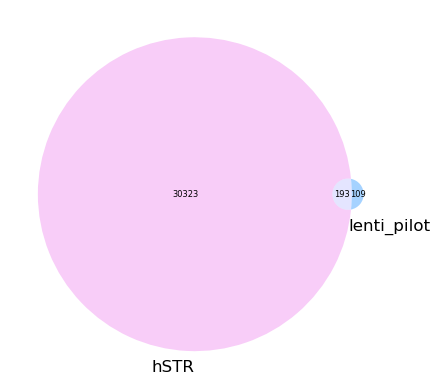

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

out = venn2([set(hSTR_list), set(lenti_list)], set_labels = ('hSTR', 'lenti_pilot'),
      set_colors=('violet', 'dodgerblue'))

for text in out.subset_labels:
   text.set_fontsize(6)

plt.show()

# Test to make sure required elements are all in the library

In [15]:
fin_df = pd.read_csv('/Users/user/Desktop/fin_order.csv')
fin_oligo = fin_df['final_oligo']

for oligo in fin_oligo:
    assert len(oligo) == PROBE_LEN
    assert (R2_PRIMER == oligo[:15])
    assert (MIN_PROMOTER in oligo)
    assert (SPACER in oligo)

In [16]:
fin_df

,name,final_oligo
0,Human_STR_1202973_m5,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
1,Human_STR_1202973_ref,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
2,Human_STR_1202973_p5,GTGCTCTTCCGATCTTCCCTTAAGAGCTGCTTTTAACATGTTTTGT...
3,Human_STR_236523_m5,GTGCTCTTCCGATCTCAGTATCCACATCATGTAGAAATGCAGATTC...
4,Human_STR_236523_ref,GTGCTCTTCCGATCTCAGTATCCACATCATGTAGAAATGCAGATTC...
...,...,...
995,CDS:APOB_Margoliash_S5_M5,GTGCTCTTCCGATCTGCCGGCTCCCTCCCGCTCCCTCTGCGCCCGC...
996,CDS:APOB_Margoliash_S5_P5,GTGCTCTTCCGATCTGCCGGCTCCCTCCCGCTCCCTCTGCGCCCGC...
997,BCL2L11_Margoliash_S5_REF,GTGCTCTTCCGATCTCGCAGGTTTCACTTCGCTCCGCGCAGCCGCC...
998,BCL2L11_Margoliash_S5_m5,GTGCTCTTCCGATCTCGCAGGTTTCACTTCGCTCCGCGCAGCCGCC...


# Manually adding oligos

In [25]:
path_genome = '/Users/user/Desktop/MPRA/lentiSTR design/hg38.fa'
genome = pyfaidx.Fasta(path_genome)

left_flank = str(genome['chr22'][42989854-54:42989854]).upper()
str_refseq = str(genome['chr22'][42989854:42989928]).upper()
right_flank = str(genome['chr22'][42989928:42989928+54]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

# left_flank = str(genome[chrom][str_start-int(np.ceil(max_context_size/2)):str_start-1]).upper()
#         str_refseq = str(genome[chrom][str_start-1:str_end]).upper()
#         right_flank = str(genome[chrom][str_end:str_end+int(np.floor(max_context_size/2))]).upper()


left: AAAAAAACAAAACAAGAAAGAAAAAAAAAAGAAAAGAAAACTCATTCTCTTGGA
str: GGGGGAAAAAAAAATATATATATATATATATACACACACACACACATATATGTATATATATGTGTGTATATATA
right: GGTAAGATGTAAGCCAGTTCAAGCATTTAAACAGGTTTAAAAAAAGAAGATATA


chr1:246507327-246507336

In [ ]:
left_flank = str(genome['chr1'][246507326-89:246507326]).upper()
str_refseq = str(genome['chr1'][246507326:246507336]).upper()
right_flank = str(genome['chr1'][246507336:246507336+89]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: TCAGACGGCTACCCGCGTCCAGCAGCGGGCGTCTCACGGGCTGCCGGGACCCGCGCGCCTGCGCCCTGCGCGCACACGTACGCCCGAGG
str: GGCGGGGCGG
right: GCGCGGTGGGGCAAGAGCATGCGCAGATGGAGTCTGGAGGGACGGCTGGAGTGGAGTGTGTGGGACCTGAAGGTGGTCGTAAGGCTCCG


In [ ]:
print(str(genome['chr2'][103039527:103039594]).upper())


ATATATATATATATATATATATATATATATATATATATATACACACACACACACACACACACACACA


chr15:78556265-78556278

In [ ]:
left_flank = str(genome['chr15'][78556264-89:78556264]).upper()
str_refseq = str(genome['chr15'][78556264:78556278]).upper()
right_flank = str(genome['chr15'][78556278:78556278+89]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: AATTGCTTGAACCCGGGAGGCAGAGGTTGCAGTGAGCCAAGATTGTGCCACTACACTCCAGCTGGGTGACAGAGTGAGACTCCATCTCC
str: AAAAAAAAAAAAAA
right: GATATTTTGCATATGAGCGTAACAATACGTTATTAGGGTCTTTCCCAGGGCCTTGGAAGGAGCCGTGCAAATGAAGAGGCTTGACTCTT


RFT1: chr3	53094347	53094397

In [28]:
left_flank = str(genome['chr3'][53094346-66:53094346]).upper()
str_refseq = str(genome['chr3'][53094346:53094397]).upper()
right_flank = str(genome['chr3'][53094397:53094397+66]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: CTGATTCAGGCCAAGGTGCTGTGTGCTGTGGAGATACGCTTTATCAAAGTGGGTGGTAAAAATACT
str: ACACGCACACACACACACACACACACACACACACACACACTCTCACACACA
right: ATACTATACTCCAACAGGAGAGATGTGCTTTCATCCGGAGTTCCAGAGAGGGAGTTTATTTGCTTT


CSTB chr21	43776445	43776479
ALOX chr10	45374100	45374137
DPYSL4 chr10	132187320	132187393
APOB chr2	21043880	21043925
BCL2L11 chr2	111120967	111121021

In [35]:
left_flank = str(genome['chr2'][111120966-63:111120966]).upper()
str_refseq = str(genome['chr2'][111120966:111121021]).upper()
right_flank = str(genome['chr2'][111121021:111121021+63]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: CGCAGGTTTCACTTCGCTCCGCGCAGCCGCCTGGTCTGCAGTTTGTTGGAGCTCTGCGTCCAG
str: CGCCGCTGCCGCTGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCC
right: ACTACCACCACTTGATTCTTGCAGCCACCCTGCGAACCCTGCCACACTGCGATCGCATCATCG


In [34]:
left_flank = str(genome['chr2'][21043879-66:21043879]).upper()
str_refseq = str(genome['chr2'][21043879:21043925]).upper()
right_flank = str(genome['chr2'][21043925:21043925+66]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: GCCGGCTCCCTCCCGCTCCCTCTGCGCCCGCAGAGCGGCCGCGCACTCACCGGCCCTGGCGCCCGC
str: CAGCAGCAGCAGCAGCAGCGCAGGCAGCGCCAGCAGCGCCAGCAGC
right: GCGGGCCTCGGCGGGTCCATCGCCAGCTGCGGTGGGGCGGCTCCTGGGCTGCGGCCTGGCCTCGGC


In [29]:
left_flank = str(genome['chr21'][43776444-66:43776444]).upper()
str_refseq = str(genome['chr21'][43776444:43776479]).upper()
right_flank = str(genome['chr21'][43776479:43776479+66]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: CGGGGAGGAGGCACTTTGGCTTCGGAGTCCCCTGCGGGGTCGCGGTGGCCCCGCAAGAAGGGACGC
str: GCGGGGCGGGGCGCGGGGCGGGGCGCGGGGCGGGG
right: AACCTGGCCACCACTCGCCGCAGGCTGGGTCTCCGCGCCCAGCGCTGGTGTCGGGAGGGAGCGCCC


In [31]:
left_flank = str(genome['chr10'][45374099-64:45374099]).upper()
str_refseq = str(genome['chr10'][45374099:45374137]).upper()
right_flank = str(genome['chr10'][45374137:45374137+64]).upper()

print("left: "  + left_flank + "\nstr: " + str_refseq + "\nright: " + right_flank)

left: CCTGCCCCGCCCGAGGCGAGGTCCCGCCCAGTCGGCGCCGCGTGAAGAGTGGGAGAGAAGTACT
str: GCGGGGGCGGGGGCGGGGGCGGGGGCGGGGGCGGGGGC
right: AGCCGGGAGCCTGGAGCCAGACCGGGGCGGGGCCGGGACCGGGGCCAGGGACCAGTGGTGGGAG
